The purpose of this notebook is to debug issues with the computed reach statistics

In [24]:
import time
import pandas
import utilities

In [25]:
regions = ['DeSoto', 'RoaringRiver', 'SpringfieldGreeneCounty', 'Windham', 'MountAscutney', 'TwoRiversOttauquechee']
for region in regions:
    df = pandas.read_parquet(f'{region}_quantiles.parquet', engine='pyarrow')
    # find null values
    null_mask = df.isnull().any(axis=1)
    nulls = df[null_mask]
    null_reaches = len(nulls.feature_id.unique())
    print(f'{region} contains {len(nulls)} NaN records, corresponding to {null_reaches} reaches\n')

DeSoto contains 0 NaN records, corresponding to 0 reaches

RoaringRiver contains 0 NaN records, corresponding to 0 reaches

SpringfieldGreeneCounty contains 10248 NaN records, corresponding to 28 reaches

Windham contains 5124 NaN records, corresponding to 14 reaches

MountAscutney contains 0 NaN records, corresponding to 0 reaches

TwoRiversOttauquechee contains 3660 NaN records, corresponding to 10 reaches



In [19]:
nulls.feature_id.unique()

array([4574819, 4574825, 4574821, 4574823, 9327666, 9327668, 9327672,
       9327674, 9327678, 9327680])

In [22]:
nulls

,index,feature_id,doy,q0,q10,q25,q75,q90,q100
17568,17568,4574819,1,NaN,NaN,NaN,NaN,NaN,NaN
17569,17569,4574819,2,NaN,NaN,NaN,NaN,NaN,NaN
17570,17570,4574819,3,NaN,NaN,NaN,NaN,NaN,NaN
17571,17571,4574819,4,NaN,NaN,NaN,NaN,NaN,NaN
17572,17572,4574819,5,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
84907,84907,9327680,362,NaN,NaN,NaN,NaN,NaN,NaN
84908,84908,9327680,363,NaN,NaN,NaN,NaN,NaN,NaN
84909,84909,9327680,364,NaN,NaN,NaN,NaN,NaN,NaN
84910,84910,9327680,365,NaN,NaN,NaN,NaN,NaN,NaN


AttributeError: 'DataFrame' object has no attribute 'q5'

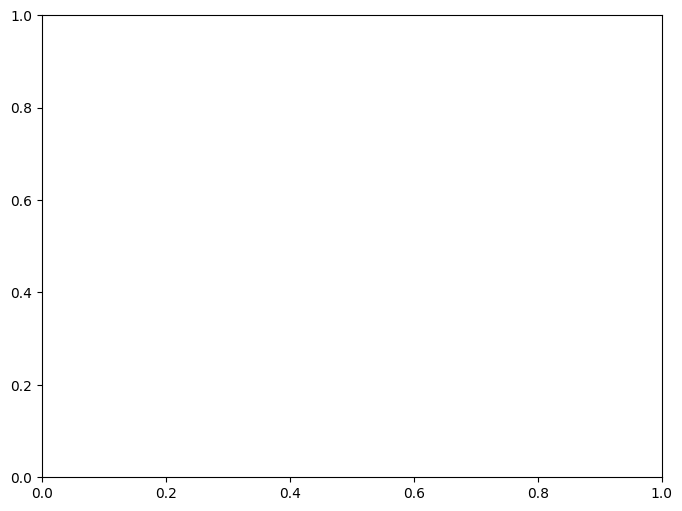

In [21]:
#random_fid = int(df.sample(n=1).feature_id.values[0])
dat = df.loc[df.feature_id == 4574819]

utilities.create_quantile_plot(dat)

In [84]:
import numpy as np

In [284]:
# def spread(data):
#     spread = np.ptp(data, axis=1)  # max - min per row
#     mean_spread = np.mean(spread)
#     return mean_spread

# def quantile_distance(data):
#     quantile_diffs = np.diff(data, axis=1)
#     mean_quantile_diff = np.mean(quantile_diffs)
#     return mean_quantile_diff

# def zero_fraction(data):
#     zero_frac = np.mean(np.all(data < 1e-6, axis=1))
#     return zero_frac

# def spikiness(data):
#     # Spikiness: mean absolute temporal derivative

#     d = data[['q10', 'q25', 'q75', 'q90']]
#     temporal_diff = np.abs(np.diff(d, axis=0))
#     mean_spike = np.mean(temporal_diff)
#     return mean_spike

# def composite_score(dat):
#     return pandas.Series({'spread': spread(dat),
#                           'quantile_distance': quantile_distance(dat),
#                           'zero_frac': zero_fraction(dat),
#                           'spikiness': spikiness(dat)})
#     return score

# def layering_metric_normalized(df, quantiles=['q10','q25','q75','q90']):
#     qvals = df[quantiles].values
#     gaps = np.diff(qvals, axis=1)
#     mean_gap = np.mean(np.abs(gaps))
#     mid_proxy = np.median((df['q25'] + df['q75']) / 2)
#     val = mean_gap / (mid_proxy + 1e-9)

#     return pandas.Series({'layering': val})



In [361]:
def detect_quantile_collapse(d, threshold=0.01):
    d.set_index('doy', inplace=True)
    diff = d.q75 - d.q25
    diff.loc[diff < threshold] = 1
    diff.loc[diff != 1] = 0
    return pandas.Series({'collapsed': sum(diff)})
    
regions = ['DeSoto', 'RoaringRiver', 'SpringfieldGreeneCounty', 'Windham', 'MountAscutney', 'TwoRiversOttauquechee']
dfs = []
for region in regions:
    df = pandas.read_parquet(f'{region}_quantiles.parquet', engine='pyarrow')
    
    # compute collapse scores
    scores = df.groupby('feature_id').apply(detect_quantile_collapse, include_groups=False)
    scores.reset_index(inplace=True)
    
    # drop reaches with too many collapses
    fids = scores[scores.collapsed <= 50].feature_id.dropna()
    good_data = df.where(df.feature_id.isin(fids)).dropna()

    dfs.append(good_data)


In [380]:
# merge data frames and save the result to parquet
all_data = pandas.concat(dfs, ignore_index=True).drop(columns=['index'])
all_data.feature_id = all_data.feature_id.astype(int)
all_data.set_index('feature_id', inplace=True)
all_data.to_parquet(f'all_quantiles_good.parquet')

In [405]:
all_data

,doy,q0,q5,q10,q25,q75,q90,q100
feature_id,,,,,,,,
3627071,1.0,0.010000,0.14,0.020000,0.080000,0.160000,0.205000,2.280000
3627071,2.0,0.010000,0.13,0.020000,0.080000,0.160000,0.180000,1.100000
3627071,3.0,0.010000,0.13,0.020000,0.080000,0.160000,0.175000,1.420000
3627071,4.0,0.010000,0.13,0.020000,0.080000,0.160000,0.180000,1.770000
3627071,5.0,0.010000,0.13,0.020000,0.080000,0.160000,0.190000,2.190000
...,...,...,...,...,...,...,...,...
9331278,362.0,82.989998,NaN,97.334998,133.207497,300.827493,470.314989,905.539980
9331278,363.0,81.079998,NaN,95.109998,128.752497,286.104994,438.464990,956.929979
9331278,364.0,79.079998,NaN,92.724998,124.167497,274.682494,360.759992,864.529981


Testing

In [ ]:
# some issues that I found
# strange series 9328724
#
# many are missing q5.

In [384]:
df = pandas.read_parquet(f'all_quantiles_good.parquet', engine='pyarrow')
df.reset_index(inplace=True)

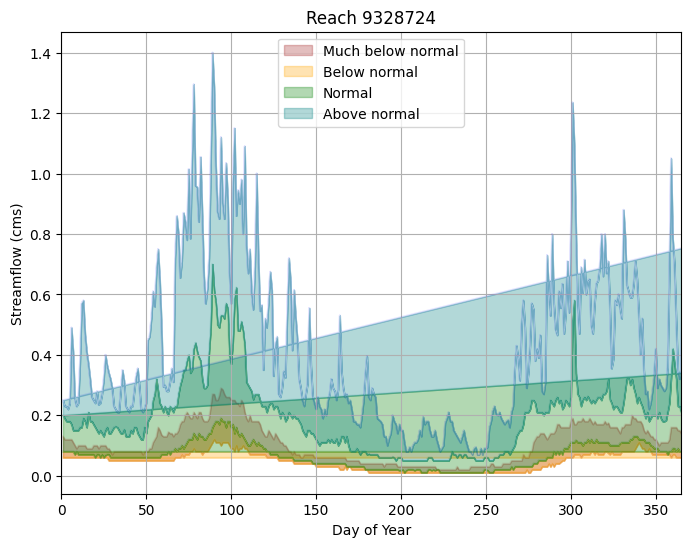

In [408]:
random_fid = int(good_data.sample(n=1).feature_id.values[0])
dat = df.loc[df.feature_id == random_fid]
create_quantile_plot(dat)

,feature_id,q0,q5,q10,q25,q75,q90,q100
doy,,,,,,,,
1.0,6083839,0.73,NaN,1.025,1.4225,3.3225,5.240,11.440000
2.0,6083839,0.72,NaN,1.005,1.3700,3.1500,4.720,10.440000
3.0,6083839,0.70,NaN,0.980,1.3875,3.0625,3.945,8.580000
4.0,6083839,0.78,NaN,0.980,1.3600,2.9500,3.660,6.320000
5.0,6083839,0.79,NaN,1.090,1.4100,2.9000,4.155,12.620000
...,...,...,...,...,...,...,...,...
362.0,6083839,0.82,NaN,1.070,1.7300,3.9525,4.880,15.160000
363.0,6083839,0.80,NaN,1.030,1.6800,3.6900,4.440,17.960000
364.0,6083839,0.80,NaN,1.110,1.5700,3.7825,4.670,27.049999
